# Week 3 - Classification

## MNIST

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset from OpenML.org:

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Accessing Data and Target arrays:

In [3]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Lets look at the X (data) and Y (target) data structure/ shape:

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

Let’s take a peek at one digit from the dataset. All we need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array,
and display it using Matplotlib’s imshow() function. We use cmap="binary" to get a grayscale color map where 0 is white and 255 is black:

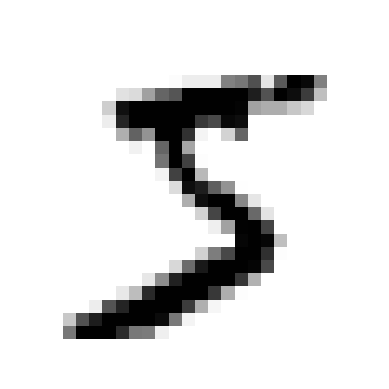

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
#save_fig("some_digit_plot")  # extra code
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [8]:
y[0]

'5'

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5. First we’ll create the target vectors for this classification task:

In [10]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Let’s create an SGDClassifier and train it on the whole training set:

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5:

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation, just as you did in Week 2:

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 5):

In [14]:
### Here is the dummy classification - Just to show that even a dummy classifier could do a good job too ###
# dummy classifier: A dummy classifier in scikit-learn is primarily used as a baseline model for comparison
# against more sophisticated models. It's called a "dummy" classifier because it doesn't learn anything from
# the data but instead makes predictions using simple rules.

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


Can you guess this model’s accuracy? Let’s find out:

In [15]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

### Confusion Matrix

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets, you can use the cross_val_predict() function: 

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the cross_val_score() function, cross_val_predict() performs k-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold.

Now you are ready to get the confusion matrix using the confusion_matrix() function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [18]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [20]:
# this cell also computes the precision: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [22]:
# this cell also computes the recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

To compute the F1 score, simply call the f1_score() function:

In [23]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [24]:
# this cell also computes the f1 score
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

### Precision/ Recall Trade-off

Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
predict() method, you can call its decision_function() method, which returns a
score for each instance, and then use any threshold you want to make predictions
based on those scores:

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [27]:
y_some_digit_pred

array([ True])

In [28]:
# just shows that y_scores > 0 produces the same result as calling predict()
y_scores > 0

array([ True])

The SGDClassifier uses a threshold equal to 0, so the preceding code returns the
same result as the predict() method (i.e., True). Let’s raise the threshold:

In [29]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 3,000.

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds (the function adds a last precision of 0 and a last recall of 1, corresponding to an infinite threshold):

In [31]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Matplotlib to plot precision and recall as functions of the threshold value:

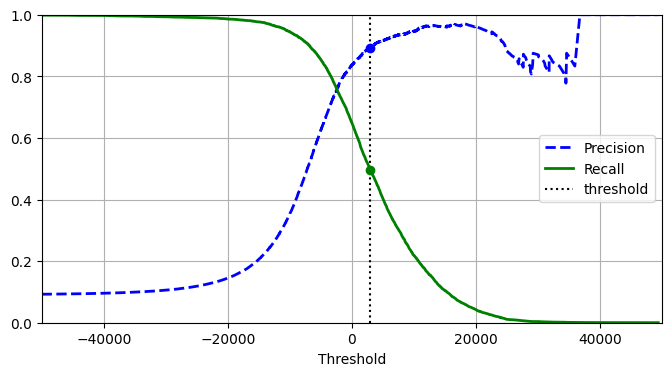

In [32]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code 
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
#save_fig("precision_recall_vs_threshold_plot")

plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall:

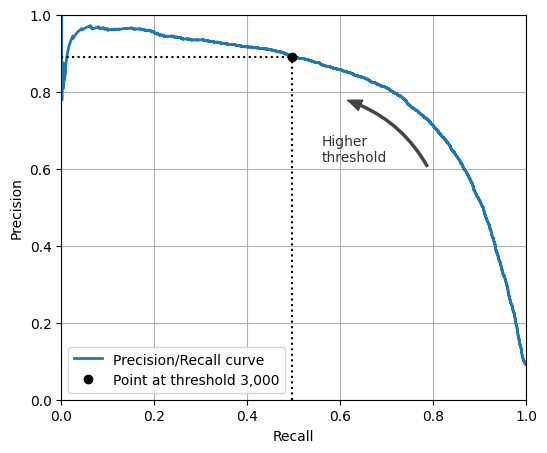

In [33]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
#save_fig("precision_vs_recall_plot")

plt.show()

Suppose you decide to aim for 90% precision. You could use the first plot to find the threshold you need to use, but that’s not very precise. Alternatively, you can search for the lowest threshold that gives you at least 90% precision. For this, you can use the NumPy array’s argmax() method. This returns the first index of the maximum value, which in this case means the first True value:

In [34]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can run this code:

In [35]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Let’s check these predictions’ precision and recall:

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [37]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

### The ROC Curve

ROC Curve is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR (also called the fall-out) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

To plot the ROC curve, you first use the roc_curve() function to compute the TPR and FPR for various threshold values:

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib. To find the point that corresponds to 90% precision, we need to look for the index of the desired threshold. Since thresholds are listed in decreasing order in this case, we use <= instead of >= on the first line:

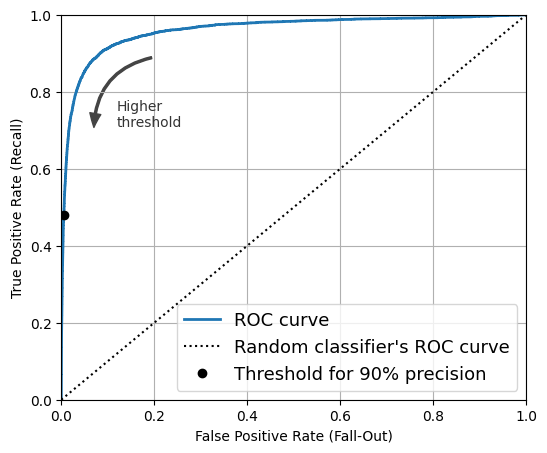

In [39]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
#save_fig("roc_curve_plot")

plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to estimate the ROC AUC:

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now create a RandomForestClassifier, whose PR curve and F1 score we can compare to those of the SGDClassifier:

This below cell may take sometime to run

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

The precision_recall_curve() function expects labels and scores for each instance, so we need to train the random forest classifier and make it assign a score to each instance. But the RandomForestClassifier class does not have a decision_function() method, due to the way it works (we will cover this later). Luckily, it has a predict_proba() method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score, so it will work fine. We can call the cross_val_predict() function to train the Random ForestClassifier using cross-validation and make it predict class probabilities for every image as follows:

In [42]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Let’s look at the class probabilities for the first two images in the training set:

In [43]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. Since each image is either positive or negative, the probabilities in each row add up to 100%.

These are estimated probabilities. Among the images that the model classified as positive with a probability between 50% and 60%, 
there are actually about 94% positive images:

In [44]:
# This just to show the probabilities. Don't expect this to be included in any of your submissions
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


The second column contains the estimated probabilities for the positive class, so let’s pass them to the precision_recall_curve() function:

In [45]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

Now we’re ready to plot the PR curve. It is useful to plot the first PR curve as well to see how they compare:

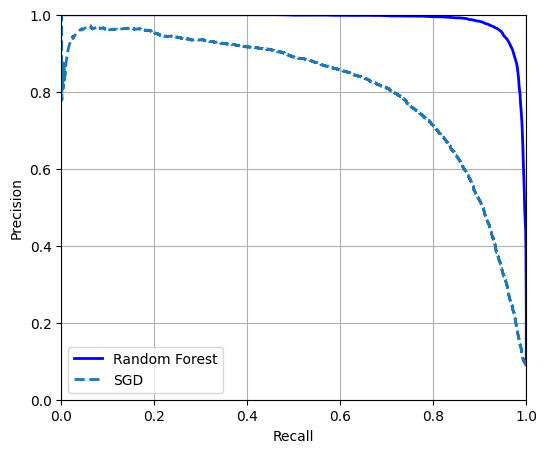

In [46]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
#save_fig("pr_curve_comparison_plot")

plt.show()

We could use cross_val_predict(forest_clf, X_train, y_train_5, cv=3) to compute y_train_pred_forest, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

As you can see in the PR figure, the RandomForestClassifier’s PR curve looks much better than the SGDClassifier’s: it comes much closer to the top-right corner. Its F1 score and ROC AUC score are also significantly better:

In [47]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Try measuring the precision and recall scores: you should find about >98% precision and >86% recall. Not too bad!

In [49]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [50]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

## Multiclass Classification

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a support vector machine classifier using the sklearn.svm.SVC class.

SVMs do not scale well to large datasets, so let's only train on the first 2,000 instances, or else this section will take a very long time to run:

In [51]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

That was easy! We trained the SVC using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Since there are 10 classes (i.e., more than 2), Scikit-Learn used the OvO strategy and trained 45 binary classifiers. Now let’s make a prediction on an image:

In [52]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

That’s correct! This code actually made 45 predictions—one per pair of classes—and it selected the class that won the most duels. If you call the decision_function() method, you will see that it returns 10 scores per instance: one per class. Each class gets a score equal to the number of won duels plus or minus a small tweak (max ±0.33) to break ties, based on the classifier scores:

In [53]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The highest score is 9.3, and it’s indeed the one corresponding to class 5:

In [54]:
class_id = some_digit_scores.argmax()
class_id

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In the case of MNIST, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class '5'), but in general you won’t be so lucky; you will need to look up the class label like this:

In [55]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [56]:
svm_clf.classes_[class_id]

'5'

If you want decision_function() to return all 45 scores, you can set the decision_function_shape hyperparameter to "ovo". The default value is "ovr", but don't let this confuse you: SVC always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated
or not:

In [57]:
# extra code – shows how to get all 45 OvO scores if needed
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it doesn’t even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [58]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

Let’s make a prediction, and check the number of trained classifiers:

In [59]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [60]:
len(ovr_clf.estimators_)

10

Training an SGDClassifier on a multiclass dataset and using it to make predictions is just as easy:

In [61]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

Oops, that’s incorrect. Prediction errors do happen! This time Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. The decision_function() method now returns one value per class. Let’s look at the scores that the SGD classifier assigned to each class:

In [62]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

You can see that the classifier is not very confident about its prediction: almost all scores are very negative, while class 3 has a score of +1,824, and class 5 is not too far behind at –1,386. Of course, you’ll want to evaluate this classifier on more than one image. Since there are roughly the same number of images in each class, the accuracy metric is fine. As usual, you can use the cross_val_score() function to evaluate the model:

The following two cells may take sometime to run:

In [63]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 85.8% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. Simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 89.1%:

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

The following cell will take sometime to run:

Since there are now 10 classes instead of 2, the confusion matrix will contain quite a lot of numbers, and it may be hard to read. A colored diagram of the confusion matrix is much easier to analyze. To plot such a diagram, use the ConfusionMatrixDisplay.from_predictions() function like this:

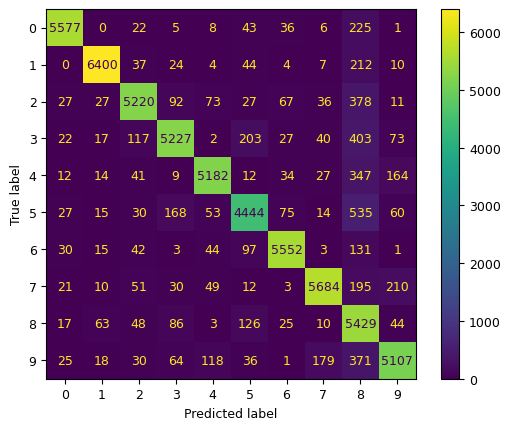

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

A better representation of CM (Normalised and in % format):

Now we can easily see that only 82% of the images of 5s were classified correctly. The most common error the model made with images of 5s was to misclassify them as 8s: this happened for 10% of all 5s. But only 2% of 8s got misclassified as 5s; confusion matrices are generally not symmetrical! If you look carefully, you will notice that many digits have been misclassified as 8s, but this is not immediately obvious from this diagram:

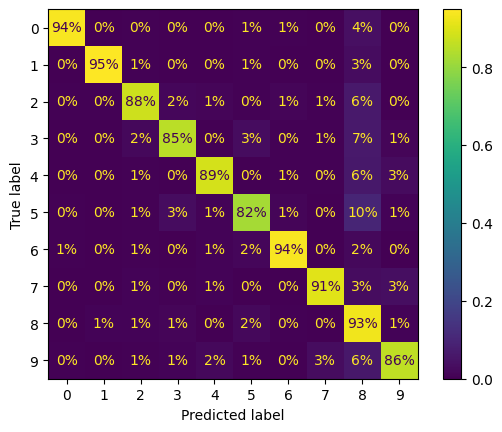

In [66]:
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

If you want to make the errors stand out more, you can try putting zero weight on the correct predictions:

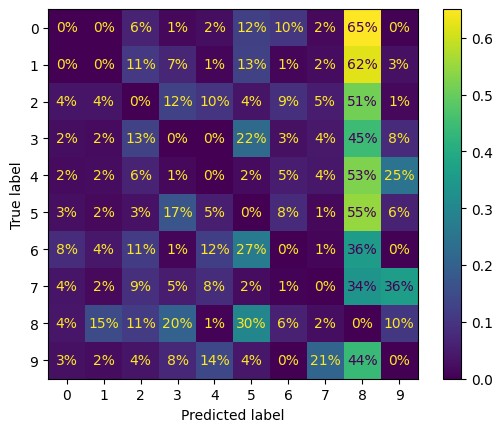

In [67]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

The column for class 8 is now really bright, which confirms that many images got misclassified as 8s. In fact this is the most common misclassification for almost all classes. But be careful how you interpret the percentages in this diagram: remember that we’ve excluded the correct predictions. For example, the 36% in row #7, column #9 does not mean that 36% of all images of 7s were misclassified as 9s. It means that 36% of the errors the model made on images of 7s were misclassifications as 9s. 